## Load data & libraries

In [4]:
!pip install stanza
!pip install unidecode
!pip install textblob
!rm development.csv
!rm development_test.csv
!wget https://pln.inf.um.es/corpora/politices/development.csv --no-check-certificate
!wget https://pln.inf.um.es/corpora/politices/development_test.csv --no-check-certificate

     |████████████████████████████████| 432 kB 6.8 MB/s 
     |████████████████████████████████| 175 kB 11.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=686630b2151f59f06e784819341a9e74890c2a6b9b7eaf8dcbe20af7c0efefdd
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 235 kB 23.4 MB/s 
rm: cannot remove 'development.csv': No such file or directory
rm: cannot remove 'development_test.csv': No such file or directory
--2022-03-15 14:34:13--  https://pln.inf.um.es/corpora/politices/development.csv
Resolving pln.inf.um.es (pln.inf.um.es)... 155.54.204.105
Connecting to pln.inf.um.es (pln.inf.um.es)|155.54.204.105|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1482900 (1.4M) [text/csv]
Saving to: ‘development.csv’

development.csv     100%[===========

In [5]:
import pandas as pd
import csv
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
import unidecode
import re

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import stanza


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stanza.download('es', package='ancora', processors='tokenize, mwt, pos, lemma', verbose=True)
stNLP = stanza.Pipeline(processors='tokenize, mwt, pos, lemma', lang='es', use_gpu=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


2022-03-08 19:38:45 INFO: Downloading these customized packages for language: es (Spanish)...
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| pretrain  | ancora  |



2022-03-08 19:38:49 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-03-08 19:38:49 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2022-03-08 19:38:49 INFO: Use device: cpu
2022-03-08 19:38:49 INFO: Loading: tokenize
2022-03-08 19:38:49 INFO: Loading: mwt
2022-03-08 19:38:49 INFO: Loading: pos
2022-03-08 19:38:49 INFO: Loading: lemma
2022-03-08 19:38:49 INFO: Done loading processors!


## Text processing

In [2]:
# lazy text processing

def entity_normalization(tweet):
    #fix some entities
    political_parties = ['podemos', 'partido popular', 'psoe', 'pp', 'ciudadanos', 'vox', 'ciu',
                         'unidas podemos', 'erc', 'esquerra republicana', 'eh bildu​', 'pnv']

    politicians = ['Pablo Iglesias', 'Pedro Sanchez', 'pedrosánchez', 'Pedro Sánchez', 'pedrosanchez', 'sánchez',
                   'pabloiglesias' 'Cayetana Álvarez Toledo', 'Donald Trump', 'donaldtrump'
                   'Trump', 'Iglesias', 'Sanchez', 'Pablo Casado', 'Monasterio', 'Rocio Monasterio', 'Irene Montero',  'Montero',
                   'Albert Rivera', 'Rivera', 'albertrivera', 'pablocasado','Casado', 'Susana Díaz', 'Susana Diaz' 'Magallanes']
    fix_labels = ['\[political_party\]','\[\#political_party\]']
    
    compile_parties = re.compile("|".join(political_parties), re.IGNORECASE)
    compile_politicians = re.compile("|".join(politicians), re.IGNORECASE)
    compile_labels = re.compile("|".join(fix_labels), re.IGNORECASE)
    
    tweet = re.sub(compile_parties, 'politicalparty', tweet.lower())
    tweet = re.sub(compile_politicians, 'personpolitician', tweet.lower())
    tweet = re.sub(compile_labels, 'politicalparty', tweet.lower())

    return tweet

def basic_processing(tweet):
  remove_digits_hashtags = re.sub('\d+|#', ' ', tweet)
  remove_extra_spaces = re.sub(' +', ' ', remove_digits_hashtags)
  remove_ents = re.sub('political_party|person_politician', ' ', remove_extra_spaces)
  return remove_ents

def lemmatize(tweet, categories=[]):
  lemmatized_tweet = stNLP(str(tweet))
  pos_lemmas = [word.lemma + '|' + word.pos for sent in lemmatized_tweet.sentences for word in sent.words]
  good_lemmas = [lemma.split('|')[0] for lemma in pos_lemmas if lemma.split('|')[-1] in categories]
  return good_lemmas

def removeStopwords(text):
    text = ' '.join(text)
    blob = TextBlob(text).words
    custom_stopwords = ['daniel','hacer','decir','tener', 'q', '@user', 'user', 'tener', 'hacer', 'estar', 'ver',
                         'dar', 'decir', 'querer', 'd', 'q', 'k', 'political_party', 'ir', 'vez', 'gran', 'mejor',
                        'preferir', 'saber']
    remove_st = [word for word in blob 
                  if word not in stopwords.words('spanish')
                  and word not in custom_stopwords]
    return(' '.join(word for word in remove_st))

def normalized_string(text):
  return unidecode.unidecode(text.lower().replace('ñ','ny'))

In [ ]:
data = pd.read_csv("development.csv") 
data = data.sort_values(by='tweet')

data['clean_data'] = data['tweet'].apply(lambda x: basic_processing(x))
data['clean_data'] = data['clean_data'].apply(lambda x: entity_normalization(x))
%time data['clean_data'] = data['clean_data'].apply(lambda x: lemmatize(x, categories=['NOUN', 'ADJ', 'VERB'])) # y adverbios?
data['clean_data'] = data['clean_data'].apply(lambda x: removeStopwords(x))
data['clean_data'] = data['clean_data'].apply(lambda x: normalized_string(x)) 

data['clean_data'] = data['clean_data'].apply(lambda x: re.sub('@user|politicalparty|political_party|volver|espl|politicalperson|politicalpar|anyo|personpolitician|personpoliticiar|gobierno|llegar|dejar', '', x))

data.to_csv('lemmatized_data.csv', sep='\t', encoding='utf-8')
data.head(10)

## Clustering

#### TD-IDF

In [ ]:
processed_data = data['clean_data'].values
tfidf = TfidfVectorizer(max_features=100, use_idf=True)
%time tdidf_matrix = tfidf.fit_transform(processed_data)
features = tfidf.get_feature_names()
terms = tfidf.vocabulary_
# terms

CPU times: user 121 ms, sys: 1.02 ms, total: 122 ms
Wall time: 132 ms


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### PCA plot

In [ ]:
labels = data['ideology_binary']

pca = PCA(n_components = 3).fit(tdidf_matrix.toarray())
X_pca = pca.transform(tdidf_matrix.toarray())

sns.set(rc={"figure.figsize":(10, 6)})
sns.scatterplot(X_pca[:,0], X_pca[:, 1], hue=labels, legend='full', palette='Set1', s=10)

In [ ]:
tfidf_df = pd.DataFrame(tdidf_matrix.toarray(), index=data['clean_data'], columns=tfidf.get_feature_names())
tfidf_df

### Aman's 3D plot

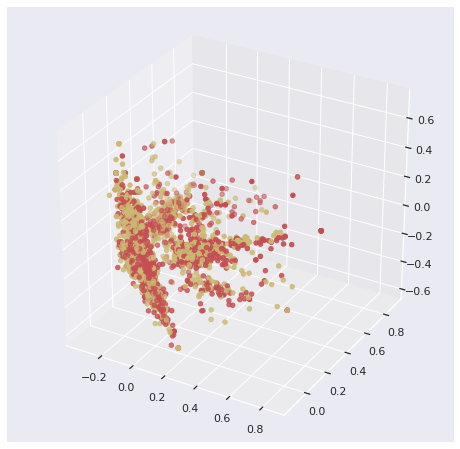

In [ ]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111,projection='3d')
ax.scatter(X_pca[:,0], X_pca[:, 1],  X_pca[:, 2],c=labels.map({'left':'y','right':'r'})) 

In [ ]:
### BERT
import torch
from transformers import AutoTokenizer, AutoModel 
from tqdm import tqdm


name = 'dccuchile/bert-base-spanish-wwm-uncased'
# 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModel.from_pretrained(name)


tokenized_tweets = []
for sen in tqdm(data.tweet):
  tok = tokenizer(sen, return_tensors='pt', max_length=50, truncation=True, padding=True)
  tokenized_tweets.append(tok)

outputs = []
with torch.no_grad():
  for tok in tqdm(tokenized_tweets):
    o = model(**tok)
    outputs.append(o[0])

ro = [torch.mean(o,1).cpu().numpy()[0] for o in outputs]

epca = PCA(n_components = 3).fit(ro)
eX_pca = epca.transform(ro) 

# LDA

In [ ]:
!pip install pyLDAvis

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

from imp import reload

import logging
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
logging.basicConfig(format='%(message)s', level=logging.INFO)

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

import itertools

In [ ]:
preprocessed_data = data

In [ ]:
def lda_topics(df_data, col, num_topics):

  tokenized_data = df_data[col].str.split()

  bg = gensim.models.Phrases(tokenized_data, min_count=3, threshold=0.1)
  bigram_mod = gensim.models.phrases.Phraser(bg)
  data_bg = bigram_mod[tokenized_data]

  dictionary = corpora.Dictionary(data_bg)
  dictionary.filter_extremes(no_below = 0.1, no_above = 0.8)
  corpus_tokens = [dictionary.doc2bow(tokens) for tokens in data_bg]
  tfidf = models.TfidfModel(corpus_tokens)
  corpus_tfidf = tfidf[corpus_tokens]

  for doc in corpus_tfidf:
    pprint(doc)
    break

  tweets = (list(itertools.chain.from_iterable(df_data[col].str.split())))
  print(tweets)
  
  def parameters():
    tfidf_vectorize = TfidfVectorizer(max_features=100, use_idf=True)
    tfidf_vectors = tfidf_vectorize.fit_transform(tweets)

    search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

    lda = LatentDirichletAllocation()

    model = GridSearchCV(lda, param_grid=search_params)

    model.fit(tfidf_vectors)
    GridSearchCV(cv=None, error_score='raise', estimator = LatentDirichletAllocation(batch_size=128, 
                                                                                   doc_topic_prior=None,
                                                                                   evaluate_every=-1,
                                                                                   learning_decay=0.7,
                                                                                   learning_method=None,
                                                                                   learning_offset=10.0,
                                                                                   max_doc_update_iter=100, 
                                                                                   max_iter=10,
                                                                                   mean_change_tol=0.001,
                                                                                   n_components=10,
                                                                                   n_jobs=1,
                                                                                   perp_tol=0.1,
                                                                                   topic_word_prior=None,
                                                                                   total_samples=1000000.0,
                                                                                   verbose=0),
                 n_jobs=1,
                 param_grid={'n_topics': [10, 15, 20, 30], 
                             'learning_decay': [0.5, 0.7, 0.9]},
                 pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
                 scoring=None, verbose=0)

    best_lda_model = model.best_estimator_
    print(best_lda_model)
    print("Best Model's Params: ", model.best_params_)
  
  # parameters()

  ldamodel_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
																							num_topics = num_topics, 
																							id2word = dictionary,
																							chunksize = 5000,
                                              alpha = 0.2,
                                              eta = 0.2,
																							passes = 10,
																							decay = 0.5,
																							iterations = 30,
                                              eval_every = 100,
                                              gamma_threshold=0.001)


  for idx, topic in ldamodel_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))
  
  def topics_per_doc():

    def format_topics_sentences(ldamodel=ldamodel_tfidf, corpus=None, texts=data):
      sent_topics_df = pd.DataFrame()
      for i, row in enumerate(ldamodel_tfidf[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
          if j == 0:
            wp = ldamodel_tfidf.show_topic(topic_num, topn=15)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
          else:
            break

      sent_topics_df.columns = ['Topic', 'Perc_Contribution', 'Topic_Keywords']

      contents = pd.Series(texts)
      sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
      return(sent_topics_df)
		
    df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel_tfidf, corpus=corpus_tfidf, texts = df_data[col])
    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Doc', 'Topic', 'PC', 'Keywords', 'Text']
    return df_dominant_topic
	
  dt = topics_per_doc()
 
  base_perplexity = ldamodel_tfidf.log_perplexity(corpus_tfidf)
  print('\nPerplexity: ', base_perplexity) 

  coherence_model = CoherenceModel(model=ldamodel_tfidf, texts=df_data[col], 
                                   dictionary=dictionary, coherence='c_v')
  coherence_lda_model_base = coherence_model.get_coherence()
  print('\nCoherence Score: ', coherence_lda_model_base)
	
  return dt
	

topics_in_tweets = lda_topics(preprocessed_data, 'clean_data', 10)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words and 0 word types
collected 77224 word types from a corpus of 78363 words (unigram + bigrams) and 5000 sentences
using 77224 counts as vocab in Phrases<0 vocab, min_count=3, threshold=0.1, max_vocab_size=40000000>
source_vocab length 77224
Phraser built with 649 phrasegrams
adding document #0 to Dictionary(0 unique tokens: [])
built Dictionary(12726 unique tokens: ['amenaza', 'asegurar', 'blanco', 'carta', 'coacciona']...) from 5000 documents (total 74364 corpus positions)
discarding 0 tokens: []...
keeping 12726 tokens which were in no less than 0 and no more than 4000 (=80.0%) documents
resulting dictionary: Dictionary(12726 unique tokens: ['amenaza', 'asegurar', 'blanco', 'carta', 'coacciona']...)
collecting document frequencies
PROGRESS: processing document #0
calculating IDF weights for 5000 documents and 12725 features (71598 matrix non-zeros)
using serial LDA version on this node
running online LDA 

[(0, 0.21229126457362832),
 (1, 0.20775044750815963),
 (2, 0.21563217188046782),
 (3, 0.22123210813068525),
 (4, 0.34126413880746476),
 (5, 0.2632960410680209),
 (6, 0.1536620209385855),
 (7, 0.165686514570824),
 (8, 0.34126413880746476),
 (9, 0.34126413880746476),
 (10, 0.22328731124071996),
 (11, 0.2384925785191484),
 (12, 0.13595880929188967),
 (13, 0.12978234976871578),
 (14, 0.37748003763573573),
 (15, 0.2490049049106159)]
['esteve', 'cosa', 'ilegal', 'rato', 'pasar', 'policia', 'amenaza', 'coacciona', 'persona', 'ocupar', 'entender', 'policia', 'consentir', 'carta', 'blanco', 'asegurar', 'extrabajador', 'cebek', 'gustar', 'propuesta', 'prorroga', 'presupuestaria', 'acuerdo', 'elegir', 'antender', 'interes', 'elite', 'gente', 'ninyo', 'euskaldun', 'forzado', 'inmersion', 'linguistico', 'arrancar', 'carrera', 'impedimenta', 'situar', 'inferioridad', 'condicion', 'vida', 'realidad', 'democratico', 'indeseable', 'franco', 'seguir', 'urkullu', 'otegi', 'contraer', 'enfermedad', 'termi

PROGRESS: pass 0, dispatched chunk #0 = documents up to #5000/5000, outstanding queue size 1
topic #2 (0.200): 0.001*"partido" + 0.001*"votar" + 0.001*"espanya" + 0.001*"persona" + 0.001*"trabajo" + 0.001*"mujer" + 0.001*"gracias" + 0.001*"dia" + 0.001*"seguir" + 0.001*"acuerdo"
topic #0 (0.200): 0.001*"espanya" + 0.001*"pedir" + 0.001*"gobernar" + 0.001*"pais" + 0.001*"apoyo" + 0.001*"familia" + 0.001*"unico" + 0.001*"izquierda" + 0.001*"democracia" + 0.001*"politica"
topic #3 (0.200): 0.001*"seguir" + 0.001*"espanya" + 0.001*"verdad" + 0.001*"madrid" + 0.001*"hablar" + 0.001*"dia" + 0.001*"gente" + 0.001*"condicion" + 0.001*"llevar" + 0.001*"canario"
topic #4 (0.200): 0.002*"gracias" + 0.001*"hablar" + 0.001*"dia" + 0.001*"nuevo" + 0.001*"espanya" + 0.001*"enhorabuena" + 0.001*"dialogo" + 0.001*"seguir" + 0.001*"persona" + 0.001*"politica"
topic #6 (0.200): 0.002*"espanya" + 0.001*"seguir" + 0.001*"pais" + 0.001*"gracias" + 0.001*"votar" + 0.001*"acabar" + 0.001*"dia" + 0.001*"solo" 

Topic: 0 Word: 0.001*"pedir" + 0.001*"espanya" + 0.001*"gobernar" + 0.001*"apoyo" + 0.001*"pais" + 0.001*"izquierda" + 0.001*"familia" + 0.001*"mayoria" + 0.001*"politico" + 0.001*"luchar"
Topic: 1 Word: 0.001*"gente" + 0.001*"pais" + 0.001*"espanya" + 0.001*"nuevo" + 0.001*"catalunya" + 0.001*"recordar" + 0.001*"vivienda" + 0.001*"dia" + 0.001*"mano" + 0.001*"seguir"
Topic: 2 Word: 0.001*"mujer" + 0.001*"gracias" + 0.001*"dia" + 0.001*"espanya" + 0.001*"trabajo" + 0.001*"partido" + 0.001*"persona" + 0.001*"acuerdo" + 0.001*"votar" + 0.001*"seguir"
Topic: 3 Word: 0.001*"seguir" + 0.001*"verdad" + 0.001*"espanya" + 0.001*"madrid" + 0.001*"hablar" + 0.001*"dia" + 0.001*"condicion" + 0.001*"congreso" + 0.001*"gente" + 0.001*"canario"
Topic: 4 Word: 0.002*"gracias" + 0.001*"dia" + 0.001*"hablar" + 0.001*"dialogo" + 0.001*"nuevo" + 0.001*"abrazo" + 0.001*"persona" + 0.001*"enhorabuena" + 0.001*"espanya" + 0.001*"trabajar"
Topic: 5 Word: 0.001*"gracias" + 0.001*"mujer" + 0.001*"dia" + 0.001*

-11.364 per-word bound, 2636.2 perplexity estimate based on a held-out corpus of 5000 documents with 17903 words
using WordOccurrenceAccumulator to estimate probabilities from sliding windows
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:193: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:194: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:189: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs



Perplexity:  -11.364258929999915

Coherence Score:  nan


In [ ]:
data_topics = pd.concat([topics_in_tweets[['Topic','Keywords']], data], axis=1)
data_topics.groupby(['Topic','Keywords', 'ideology_binary'])['ideology_binary'].size()

Topic  Keywords                                                                                                                          ideology_binary
0.0    espanya, dia, pais, mundo, gracias, gente, nuevo, political_party, hablar, poner, seguir, enhorabuena, derecha, pueblo, ley       left               589
                                                                                                                                         right              488
1.0    gracias, dia, politica, votar, mujer, seguir, congreso, pais, derecho, cosa, justicia, preguntar, ley, espanya, social            left               544
                                                                                                                                         right              446
2.0    espanya, catalunya, gracias, persona, dia, pedir, politica, apoyo, hablar, dialogo, votar, presupuesto, publico, llevar, cumplir  left               428
                                               

In [ ]:
data_topics

,Topic,Keywords,Unnamed: 0,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,0.0,"political_party, gobierno, espana, ano, espano...",36617,@user10,male,journalist,right,moderate_right,"[ee, uu, china, grande, pelear, mundo, resfrir..."
1,0.0,"political_party, gobierno, espana, ano, espano...",11991,@user10,male,journalist,right,moderate_right,"[sensacion, previsible, hora, alegria, politic..."
2,1.0,"political_party, dia, sanchez, ano, llegar, ha...",40804,@user10,male,journalist,right,moderate_right,"[salvar, quedar, inmovil, borde, camino, conge..."
3,0.0,"political_party, gobierno, espana, ano, espano...",48101,@user10,male,journalist,right,moderate_right,"[militar, venezolano, bajo, rango, solicitar, ..."
4,1.0,"political_party, dia, sanchez, ano, llegar, ha...",27627,@user10,male,journalist,right,moderate_right,"[rivera, sanchez, mayoria, absoluto, diputados..."
...,...,...,...,...,...,...,...,...,...
4995,0.0,"political_party, gobierno, espana, ano, espano...",6914,@user96,female,politician,right,moderate_right,"[dani, mateo, insistir, catalunya, radio, gana..."
4996,1.0,"political_party, dia, sanchez, ano, llegar, ha...",39390,@user96,female,politician,right,moderate_right,"[condenado, apologia, terrorismo, extremo, der..."
4997,1.0,"political_party, dia, sanchez, ano, llegar, ha...",44724,@user96,female,politician,right,moderate_right,"[cuidemono, colaboracion, lealtad, carmen, cal..."
4998,0.0,"political_party, gobierno, espana, ano, espano...",39401,@user96,female,politician,right,moderate_right,"[contar, political_party, gobierno, pasar, dia..."
